# K分割交差検証法：Cross Validation
　クロスバリデーションのサンプルプログラム. **理解のためや, オリジナルのクロスバリデーションを書けるようにライブラリは使用しない.**

In [202]:
import numpy as np
import pandas as pd
import math

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
    
import seaborn as sns
import matplotlib.pyplot as plt

## Setting

In [203]:
# Path
input_path = "../input_data/"

# Figure Size
plt.rcParams["figure.figsize"] = (15.0, 10.0)

In [204]:
def model_xvalid(train,K=5,max_depth=5,min_samples_split=2,min_samples_leaf=1):
        
    # 再現性のためシードを固定
    np.random.seed(17)

    # グループ分け
    train = pd.get_dummies(train, drop_first=True)
    train["cv_group"] = np.random.randint(0, K, train.shape[0])

    # Cross Validation
    train_score = []
    valid_score = []
    for i in range(K):
        # 構築, 検証に分ける
        train_tmp = train[train["cv_group"] != i].drop("cv_group", axis = 1).copy()
        valid_tmp = train[train["cv_group"] == i].drop("cv_group", axis = 1).copy()
    
        train_x = train_tmp.drop(columns = ["y"])
        train_y = train_tmp[["y"]]
        
        valid_x = valid_tmp.drop(columns = ["y"])
        valid_y = valid_tmp[["y"]]
        
        # Make Model
        tree_model = DecisionTreeClassifier(
            criterion = "gini",                # Entropy基準の場合は"entropy”
            splitter = "best",                 # 分割をランダムで行う場合は"random"
            random_state=17,                   # 同じ分割スコアの時にランダムに選ぶseedを固定
            max_depth = max_depth,                     # 決定木の深さの最大値
            min_samples_split = min_samples_split,             # 分割する最小データ数
            min_samples_leaf = min_samples_leaf,              # 末端ノードに該当する最小サンプル数
            ccp_alpha=0,                        # 枝刈りの強さ(非負)※最初はあまりいじらなくて良い
            class_weight="balanced"
        )
        tree_model = tree_model.fit(train_x, train_y)
        
        # 構築データのAUC
        pred = tree_model.predict_proba(train_x)[:, 1]
        train_score.append(roc_auc_score(train_y, pred))
        
        # 検証データのAUC
        pred = tree_model.predict_proba(valid_x)[:, 1]
        valid_score.append(roc_auc_score(valid_y, pred))
    
    print("train score:", sum(train_score) / K," valid score:",sum(valid_score) / K)

## Read Data and Make Data

In [205]:
train = pd.read_csv(
    input_path + "bank/train.csv",
    sep = ",",
    header = 0,
    quotechar = "\""
)

## Transforming set

In [210]:
train1 = train.drop(columns="id").copy()
train1["not_contacted"] = train1["pdays"] == -1
train1["overdraft"] = train1["balance"] < 0
print("Before:")
model_xvalid(train,5,6,2,22)
print("After:")
model_xvalid(train1,5,6,2,22)

Before:
train score: 0.8976527172999471  valid score: 0.8842397020005283
After:
train score: 0.8976076952225274  valid score: 0.8843850992251454


In [211]:
train2 = train1.copy()
train2["contact_Q1"] = train2["month"].isin(["jan","feb","mar"])
train2["contact_Q2"] = train2["month"].isin(["apr","may","jun"])
train2["contact_Q3"] = train2["month"].isin(["jul","aug","sep"])
train2["contact_Q4"] = train2["month"].isin(["oct","nov","dec"])
#train2.drop(columns="month",inplace=True)
print("Before:")
model_xvalid(train1,5,6,2,22)
print("After:")
model_xvalid(train2,5,6,2,22)

Before:
train score: 0.8976076952225274  valid score: 0.8843850992251454
After:
train score: 0.8993039125654722  valid score: 0.8851946340854999


In [212]:
train3 = train2.copy()
train3["loan_free"] = (train3["loan"] == "no") & (train3["housing"] == "no")
print("Before:")
model_xvalid(train2,5,6,2,22)
print("After:")
model_xvalid(train3,5,6,2,22)

Before:
train score: 0.8993039125654722  valid score: 0.8851946340854999
After:
train score: 0.9013498227918454  valid score: 0.889700759261572


In [213]:
train4 = train3.copy()
train4["single"] = train4["marital"] == "single"
#train4.drop(columns=["marital"],inplace=True)
print("Before:")
model_xvalid(train3,5,6,2,22)
print("After:")
model_xvalid(train4,5,6,2,22)

Before:
train score: 0.9013498227918454  valid score: 0.889700759261572
After:
train score: 0.9013498227918454  valid score: 0.8897197944222228


In [216]:
train5= train4.copy()
train5["rich"] = train5["balance"] >= 3500 # top 10%
train5["middle"] = (train5["balance"] > 500) & (train5["balance"] < 3500) # 50-90%
train5["poor"] = (train5["balance"] <= 500) & (train5["balance"] > 0) # 50% cut off

train5["age_group"] = (train5["age"] // 10) * 10
train5["age_balance_z"]= train5.groupby("age_group")["balance"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
train5["job_balance_z"]= train5.groupby("job")["balance"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
#train5["edu_balance_z"]= train5.groupby("education")["balance"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))

#train5["campaign_duration"] = (train5["campaign"] + 0.5) * (train5["duration"] + 0.5)
#train5["balance_by_effort"] = train5["balance"] / train5["campaign_duration"]

#train5.drop(columns="balance",inplace=True)

print("Before:")
model_xvalid(train4,5,6,2,22)
print("After:")
model_xvalid(train5,5,6,2,22)

Before:
train score: 0.9013498227918454  valid score: 0.8897197944222228
After:
train score: 0.9014216150763179  valid score: 0.8897231482061227


In [217]:
train6=train5.copy()
train6["long_call"] = train6["duration"] > 180
train6["short_call"] = (train6["duration"] > 0) & (train6["duration"] <= 180)
train6["over_campaign"] = train6["campaign"] >= 20
train6["p_success"] = train6["poutcome"] == "success"
#train6.drop(columns=["poutcome","campaign","age"],inplace=True)
print("Before:")
model_xvalid(train5,5,6,2,22)
print("After:")
model_xvalid(train6,5,6,2,22)

Before:
train score: 0.9014216150763179  valid score: 0.8897231482061227
After:
train score: 0.9014216150763179  valid score: 0.8897653736904871


In [218]:
train7=train6.copy()
train7["contact_unknown"] = train7["contact"] == "unknown"
train7["day_in_year"] = pd.to_datetime( train["month"] + " " + train["day"].astype(str) + " 2021", format="%b %d %Y").dt.dayofyear

#train7.drop(columns="contact",inplace=True)
print("Before:")
model_xvalid(train6,5,6,2,22)
print("After:")
model_xvalid(train7,5,6,2,22)

Before:
train score: 0.9014216150763179  valid score: 0.8897653736904871
After:
train score: 0.9068976751075836  valid score: 0.8918901203848071


In [219]:
train7

,age,job,marital,education,default,balance,housing,loan,contact,day,...,poor,age_group,age_balance_z,job_balance_z,long_call,short_call,over_campaign,p_success,contact_unknown,day_in_year
0,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,...,False,30,0.211508,0.337396,True,False,False,False,False,93
1,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,...,False,50,-0.062512,-0.047795,False,True,False,False,False,49
2,36,management,single,tertiary,no,436,no,no,cellular,13,...,True,30,-0.296912,-0.349365,True,False,False,False,False,103
3,63,retired,married,secondary,no,474,no,no,cellular,25,...,True,60,-0.435358,-0.427152,True,False,False,False,False,25
4,31,management,single,tertiary,no,354,no,no,cellular,30,...,True,30,-0.328496,-0.370534,True,False,False,True,False,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,42,blue-collar,married,primary,no,1455,yes,no,cellular,2,...,False,40,0.039777,0.194193,True,False,False,False,False,33
27124,34,services,single,secondary,no,719,yes,no,unknown,15,...,False,30,-0.187910,-0.117135,True,False,False,False,True,135
27125,36,blue-collar,single,primary,no,49,yes,no,unknown,8,...,True,30,-0.445972,-0.474721,True,False,False,False,True,128
27126,33,housemaid,married,primary,no,209,no,no,cellular,12,...,True,30,-0.384345,-0.392973,False,True,False,False,False,224


In [226]:
train = pd.get_dummies(train7)
model_xvalid(train,5,6,2,7)
train.keys()

train score: 0.9076384014249392  valid score: 0.8895700532284432


Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y', 'not_contacted', 'overdraft', 'contact_Q1', 'contact_Q2',
       'contact_Q3', 'contact_Q4', 'loan_free', 'single', 'rich', 'middle',
       'poor', 'age_group', 'age_balance_z', 'job_balance_z', 'long_call',
       'short_call', 'over_campaign', 'p_success', 'contact_unknown',
       'day_in_year', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan'

## max_depthを動かしてチューニング

In [462]:
#train = pd.get_dummies(train4, drop_first=True)

# 分割数
K = 5

# 再現性のためシードを固定
np.random.seed(17)

# グループ分け
train["cv_group"] = np.random.randint(0, K, train.shape[0])


# チューニング
train_auc = []
valid_auc = []
search_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for j in search_list:
    
    # Cross Validation
    train_score = []
    valid_score = []
    
    for i in range(K):
        # 構築, 検証に分ける
        train_tmp = train[train["cv_group"] != i].drop("cv_group", axis = 1).copy()
        valid_tmp = train[train["cv_group"] == i].drop("cv_group", axis = 1).copy()

        train_x = train_tmp.drop(columns = ["y"])
        train_y = train_tmp[["y"]]

        valid_x = valid_tmp.drop(columns = ["y"])
        valid_y = valid_tmp[["y"]]

        # Make Model
        tree_model = DecisionTreeClassifier(
            criterion = "gini",                # Entropy基準の場合は"entropy”
            splitter = "best",                 # 分割をランダムで行う場合は"random"
            random_state=17,                   # 同じ分割スコアの時にランダムに選ぶseedを固定
            max_depth = j,                     # 決定木の深さの最大値
            min_samples_split = 2,             # 分割する最小データ数
            min_samples_leaf = 25,              # 末端ノードに該当する最小サンプル数
            ccp_alpha=0,                       # 枝刈りの強さ(非負)※最初はあまりいじらなくて良い
            class_weight="balanced"
        )
        tree_model = tree_model.fit(train_x, train_y)

        # 構築データのAUC
        pred = tree_model.predict_proba(train_x)[:, 1]
        train_score.append(roc_auc_score(train_y, pred))

        # 検証データのAUC
        pred = tree_model.predict_proba(valid_x)[:, 1]
        valid_score.append(roc_auc_score(valid_y, pred))
        
    train_auc.append(sum(train_score) / K)
    valid_auc.append(sum(valid_score) / K)

## 過学習の確認 - depth

In [463]:
g_train = pd.DataFrame(
    np.array([search_list, train_auc]).T,
    columns = ["Search", "AUC"]
)
g_train["Data"] = "train"

g_valid = pd.DataFrame(
    np.array([search_list, valid_auc]).T,
    columns = ["Search", "AUC"]
)
g_valid["Data"] = "valid"

g_dat = pd.concat([g_train, g_valid])
g_dat.loc[g_dat.groupby("Data").AUC.idxmax()]

,Search,AUC,Data
11,12.0,0.949111,train
11,12.0,0.895269,valid
6,7.0,0.922759,train
6,7.0,0.904226,valid


[(0.7, 0.95)]

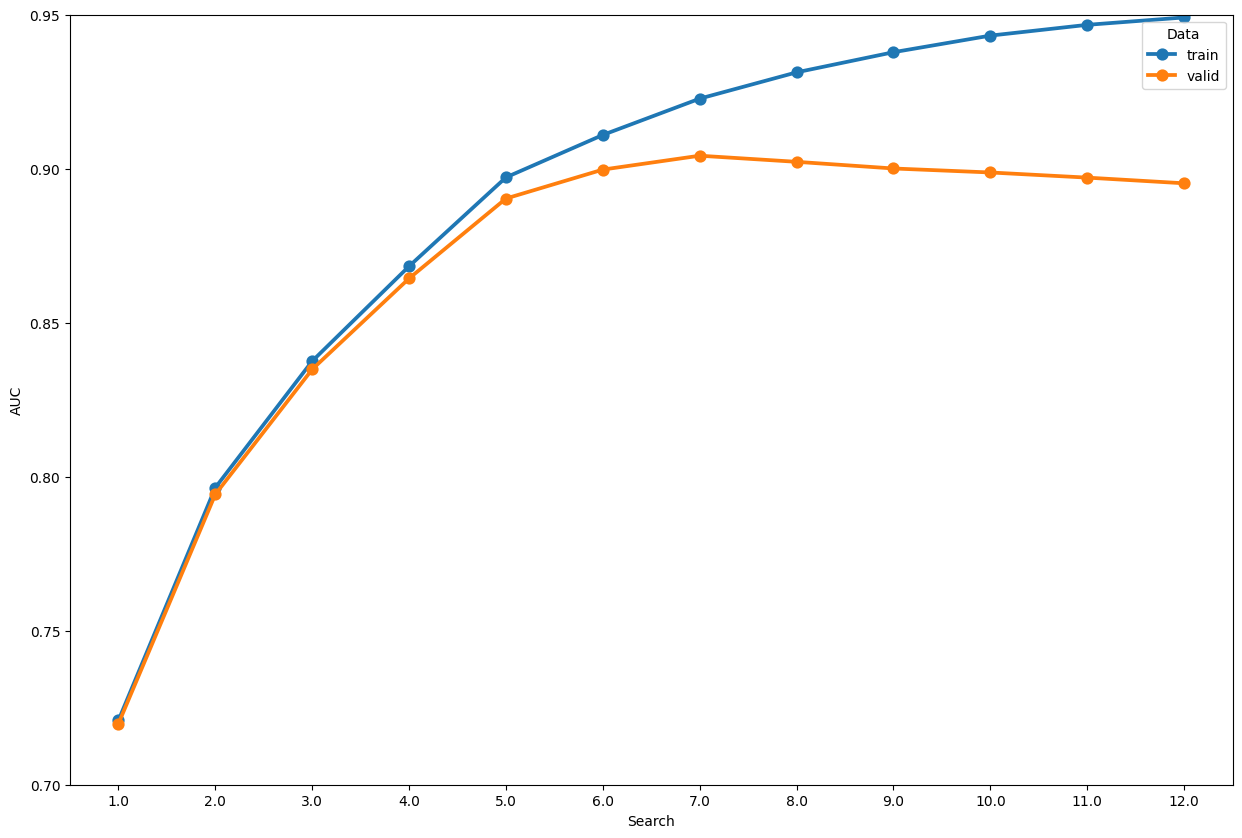

In [464]:
sns.pointplot(
    data = g_dat,
    x = "Search",
    y = "AUC",
    hue = "Data"
).set(ylim = (0.7, 0.95))

## splitを動かしてチューニング

In [460]:
# 分割数
K = 5

# 再現性のためシードを固定
np.random.seed(17)

# グループ分け
train["cv_group"] = np.random.randint(0, K, train.shape[0])


# チューニング
train_auc = []
valid_auc = []
search_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
for j in search_list:
    
    # Cross Validation
    train_score = []
    valid_score = []
    
    for i in range(K):
        # 構築, 検証に分ける
        train_tmp = train[train["cv_group"] != i].drop("cv_group", axis = 1).copy()
        valid_tmp = train[train["cv_group"] == i].drop("cv_group", axis = 1).copy()

        train_x = train_tmp.drop(columns = ["y"])
        train_y = train_tmp[["y"]]

        valid_x = valid_tmp.drop(columns = ["y"])
        valid_y = valid_tmp[["y"]]

        # Make Model
        tree_model = DecisionTreeClassifier(
            criterion = "gini",                # Entropy基準の場合は"entropy”
            splitter = "best",                 # 分割をランダムで行う場合は"random"
            random_state=17,                   # 同じ分割スコアの時にランダムに選ぶseedを固定
            max_depth = 7,                     # 決定木の深さの最大値
            min_samples_split = 2,             # 分割する最小データ数
            min_samples_leaf = j,              # 末端ノードに該当する最小サンプル数
            ccp_alpha=0,                        # 枝刈りの強さ(非負)※最初はあまりいじらなくて良い
            class_weight="balanced"
        )
        tree_model = tree_model.fit(train_x, train_y)

        # 構築データのAUC
        pred = tree_model.predict_proba(train_x)[:, 1]
        train_score.append(roc_auc_score(train_y, pred))

        # 検証データのAUC
        pred = tree_model.predict_proba(valid_x)[:, 1]
        valid_score.append(roc_auc_score(valid_y, pred))
        
    train_auc.append(sum(train_score) / K)
    valid_auc.append(sum(valid_score) / K)

g_train = pd.DataFrame(
    np.array([search_list, train_auc]).T,
    columns = ["Search", "AUC"]
)
g_train["Data"] = "train"

g_valid = pd.DataFrame(
    np.array([search_list, valid_auc]).T,
    columns = ["Search", "AUC"]
)
g_valid["Data"] = "valid"

g_dat = pd.concat([g_train, g_valid])
g_dat.loc[g_dat.groupby("Data").AUC.idxmax()]

,Search,AUC,Data
6,8.0,0.924600,train
6,8.0,0.900673,valid
23,25.0,0.922759,train
23,25.0,0.904226,valid


[(0.8, 1.0)]

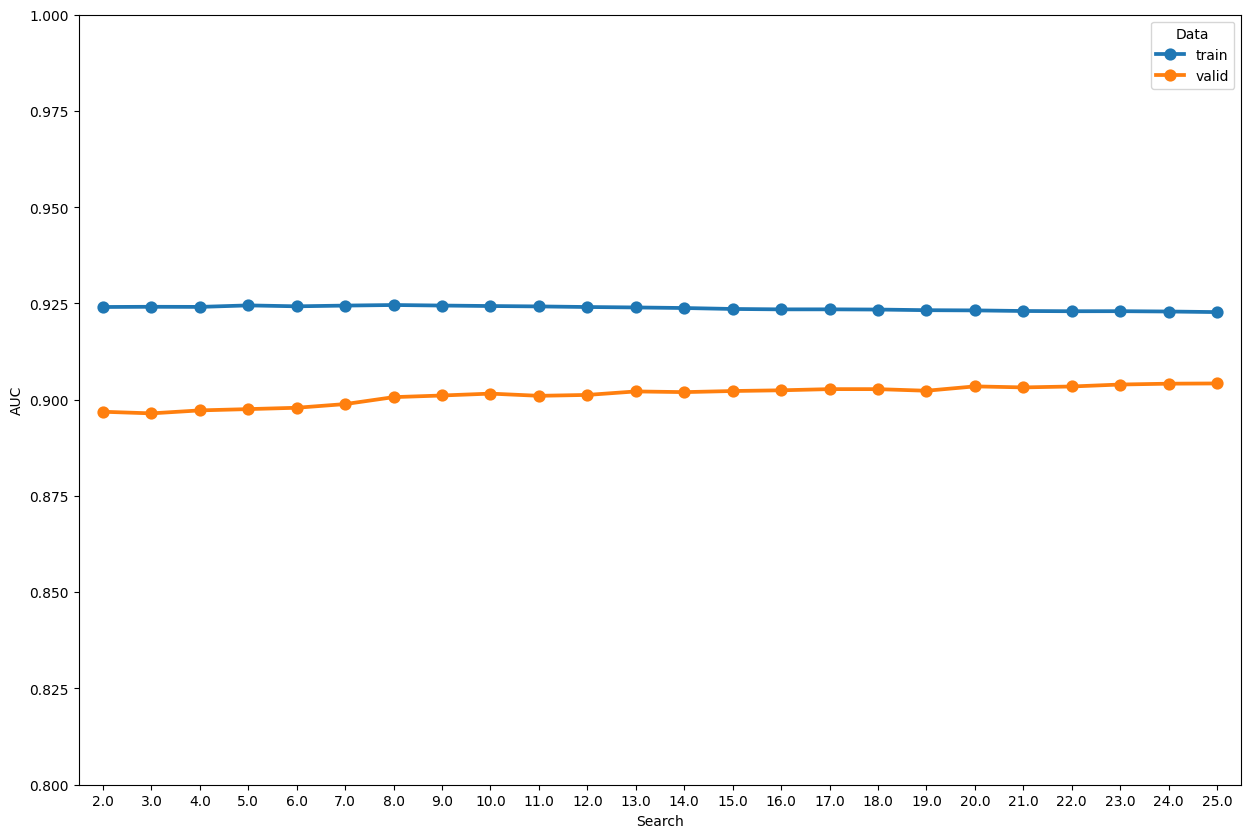

In [461]:
sns.pointplot(
    data = g_dat,
    x = "Search",
    y = "AUC",
    hue = "Data"
).set(ylim = (0.8, 1))

## Prepping for submission

In [446]:
def optimize_bank(data):
    data = data.copy().drop("id",axis=1)
    data["not_contacted"] = data["pdays"] == -1
    #data["overdraft"] = data["balance"] < 0
    #data["contact_Q1"] = data["month"].isin(["jan","feb","mar"])
    data["contact_Q2"] = data["month"].isin(["apr","may","jun"])
    #data["contact_Q3"] = data["month"].isin(["jul","aug","sep"])
    #data["contact_Q4"] = data["month"].isin(["oct","nov","dec"])
    month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
                 'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    data["month_num"] = data["month"].map(month_map)
    data["month_sin"] = np.sin(2*np.pi*data["month_num"]/12)
    #data["month_cos"] = np.cos(2*np.pi*data["month_num"]/12)
    data["loan_free"] = (data["loan"] == "no") & (data["housing"] == "no")
    #data["single"] = data["marital"] == "single"
    #data["rich"] = data["balance"] >= 3500 # top 10%
    #data["middle"] = (data["balance"] > 500) & (data["balance"] < 3500) # 50-90%
    #data["poor"] = (data["balance"] <= 500) & (data["balance"] > 0) # 50% cut off
    data["age_group"] = (data["age"] // 10) * 10
    data["age_balance_z"]= data.groupby("age_group")["balance"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    data["job_balance_z"]= data.groupby("job")["balance"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    data["is_mng"] = data["job"] == "management"
    #data["long_call"] = data["duration"] > 180
    #data["short_call"] = (data["duration"] > 0) & (data["duration"] <= 180)
    #data["over_campaign"] = data["campaign"] >= 20
    data["p_success"] = data["poutcome"] == "success"
    data["campaign_duration"] = (data["campaign"] + 1) * (data["duration"] + 1)
    data["balance_by_effort"] = data["balance"] / data["campaign_duration"]
    #data["efficiency"] = data["duration"] / (data["campaign"] + 1)  # cost-effectiveness
    #data["log_efficiency"] = np.log1p(data["efficiency"])           # normalize skew
    data["contact_unknown"] = data["contact"] == "unknown"
    #data["good_call"] = (~data["contact_unknown"]) & (data["long_call"])
    data["day_in_year"] = pd.to_datetime( data["month"] + " " + data["day"].astype(str) + " 2021", format="%b %d %Y").dt.dayofyear
    #data["job_x_age_z"]= data["age_balance_z"] * data["job_balance_z"]

    data.drop(columns=["campaign",
                       "previous",
                       "pdays",
                       "job",
                       "balance",
                       "poutcome",
                       "marital",
                       "month",
                       "contact",
                       "day",
                       "age_group",
                       "education",
                       "month_num",
                       "default"
                      ],inplace=True)
    
    data = pd.get_dummies(data)
    return data

In [465]:
train = pd.read_csv(input_path + "bank/train.csv", sep=",", header=0, quotechar="\"")
train = optimize_bank(train)
model_xvalid(train,5,7,2,25)

train score: 0.9227591706474472  valid score: 0.9042264456767344


### Read data

In [470]:
train = pd.read_csv(input_path + "bank/train.csv", sep=",", header=0, quotechar="\"")
test = pd.read_csv(input_path + "bank/test.csv", sep=",", header=0, quotechar="\"")

train = optimize_bank(train)
test = optimize_bank(test)
model_xvalid(train,5,7,2,25)

train = pd.get_dummies(train) # drop_first=Trueでk-1個のダミー変数となる
test_x = pd.get_dummies(test)

train_x = train.drop(columns=["y"])
train_y = train[["y"]]

tree_model = DecisionTreeClassifier(
    criterion="gini", 
    splitter="best",
    random_state=17,
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=25,
    ccp_alpha=0,
    class_weight="balanced"
)
tree_model = tree_model.fit(train_x, train_y)
pred = tree_model.predict_proba(train_x)[:, 1]
roc_auc_score(train_y, pred)

feat_importances = pd.DataFrame({
    "feature": train_x.columns,
    "importance": tree_model.feature_importances_
})

feat_importances = feat_importances.sort_values("importance", ascending=False)
print(feat_importances.head(35))

train score: 0.9227591706474472  valid score: 0.9042264456767344
              feature  importance
1            duration    0.483798
13        day_in_year    0.113141
12    contact_unknown    0.105479
9           p_success    0.104577
5           loan_free    0.062316
4           month_sin    0.051512
2       not_contacted    0.023138
0                 age    0.018112
14         housing_no    0.014750
3          contact_Q2    0.007620
10  campaign_duration    0.004601
6       age_balance_z    0.003819
16            loan_no    0.002636
7       job_balance_z    0.002184
11  balance_by_effort    0.001445
8              is_mng    0.000872
15        housing_yes    0.000000
17           loan_yes    0.000000


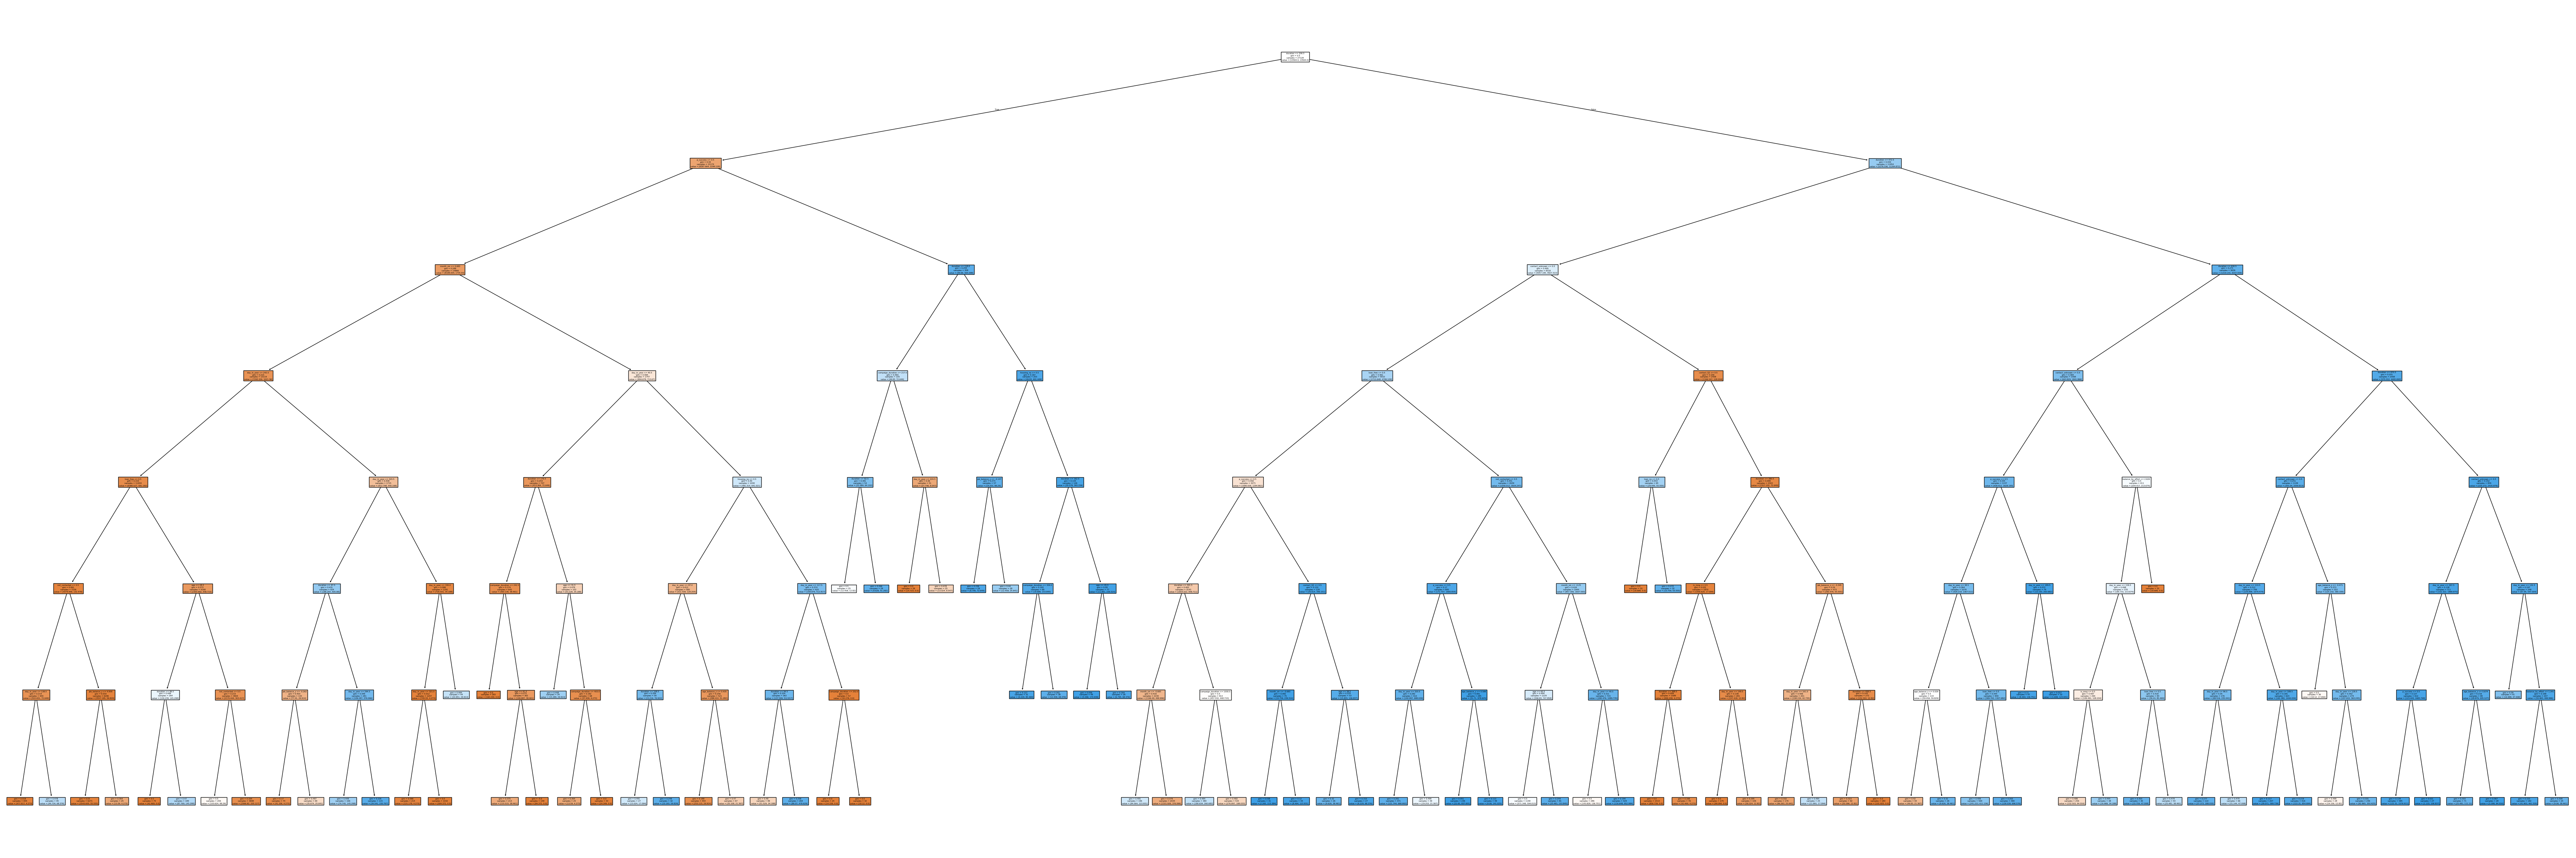

In [471]:
col_name = list(train_x.columns.values)
fig = plt.figure(figsize=(30*3, 10*3))
ax = fig.add_subplot()
split_info = plot_tree(tree_model, feature_names=col_name, ax=ax, filled=True)

In [472]:
pred_test = tree_model.predict_proba(test_x)[:, 1]
submit = pd.read_csv(input_path + "bank/test.csv", sep=",", header=0, quotechar="\"")[["id"]].copy()
submit["pred"] = pred_test
submit.to_csv(
    path_or_buf="../submit/submit_tree_20250909_2.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=False                                        # headerの出力有無
)